# Perform the gauge transformation at exact mid-rapidity

Set the relevant parameters and valiables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2.5         
N = 128 
tau_sim = 1.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.68        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.2 * g**2 * mu         
uv = 10.0       


nevents = 1

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Define the simulation routine

In [11]:
from tqdm import tqdm 

# Simulation routine
def simulate():
    
    # Dictionary to store the results
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N/L*hbarc
    DT = 1.0/DTS 
    maxt = int(tau_sim/a*DTS)
    
    # We create the object Glasma Simulation
    s = core.Simulation(N, DT, g)
    
    # We intialize the Glasma fields
    va = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create an object to store the fields at every time step
    ux_sim = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create objects to store the plus links links
    up_temp = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the gauge transformation operator
    vlc_dag = np.zeros((maxt//DTS, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the plus links in lc gauge
    up_lc = np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We set them to unit
    for xplus in range(maxt//DTS):
        for y in range(N):
            for z in range(N):
                up_temp[xplus, y, z] = su.unit()
    
    
    # We start the simulation
    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            # When we reach a multiple of DTS we store the plus links
            if t%DTS == 0:
                xplus = t//DTS
                
                u1 = s.u1.copy()
                ux_sim[xplus] = u1[:, 0, :].reshape(N, N, su.GROUP_ELEMENTS)
                
                for y in range(N):
                    for z in range(N):
                        # We construct the plus links in temporal gauge
                        up_temp[xplus, y, z] = ux_sim[xplus, xplus, y]
                        
                        # We construct the gauge transformation operator
                        vlc0 = su.unit(); vlc1 = su.unit()
                        for xminus in range(0, -xplus, -1):
                            vlc1 = su.mul(vlc0, ux_sim[xplus+xminus-1, xplus-xminus, y])
                            vlc0 = np.copy(vlc1)
                        vlc_dag[xplus, y] = vlc1

                        # We perform the gauge transformation of the field at the previous time step
                        aux = su.mul(up_temp[(xplus-1), y, z], vlc_dag[xplus, y])
                        aux2 = su.mul(su.dagger(vlc_dag[(xplus-1), y]), aux)
                        up_lc[(xplus-1), y, z] = su.dagger(aux2)
                    
            for y in range(N):
                for z in range(N):
                    up_lc[0, y, z] = su.unit()
                            
                            
            pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    up_jetsim = up_lc.reshape(maxt//DTS-1, N*N, su.GROUP_ELEMENTS)
    
    output['up_temp'] = up_temp
    output['up_lc'] = up_lc
    output['up_jetsim'] = up_jetsim
    
    return output

In [12]:
# We perform the simulation
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    output = simulate()
    up_temp = output['up_temp']
    up_lc = output['up_lc']
    up_jetsim = output['up_jetsim']
    
    np.save(os.path.join('simulations', 'mid_rapidity', 'result_%i.npy' %n), up_jetsim)

Kernel xi: 0 d:  0 did not reach goal. check:  0.00030696183549676657
Kernel xi: 0 d:  1 did not reach goal. check:  0.0022168220957924575
Kernel xi: 1 d:  0 did not reach goal. check:  0.000528154937664431
Kernel xi: 1 d:  1 did not reach goal. check:  0.002533875622202836
Kernel xi: 2 d:  0 did not reach goal. check:  0.0010099832612083348
Kernel xi: 2 d:  1 did not reach goal. check:  0.0039809328477024885
Kernel xi: 3 d:  0 did not reach goal. check:  0.0017594156400686557
Kernel xi: 3 d:  1 did not reach goal. check:  0.00629761869066894
Kernel xi: 4 d:  0 did not reach goal. check:  0.002135332249600263
Kernel xi: 4 d:  1 did not reach goal. check:  0.006803914783873492
Kernel xi: 5 d:  0 did not reach goal. check:  0.0023856181580658507
Kernel xi: 5 d:  1 did not reach goal. check:  0.0046769086647520455
Kernel xi: 6 d:  0 did not reach goal. check:  0.0025395453409942505
Kernel xi: 6 d:  1 did not reach goal. check:  0.0017989984180450704
Kernel xi: 7 d:  0 did not reach goal. 

100%|██████████| 512/512 [01:16<00:00,  6.72it/s]


We plot the results

In [13]:
# Extract the color components
up_temp_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_temp)
up_lc_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_lc)

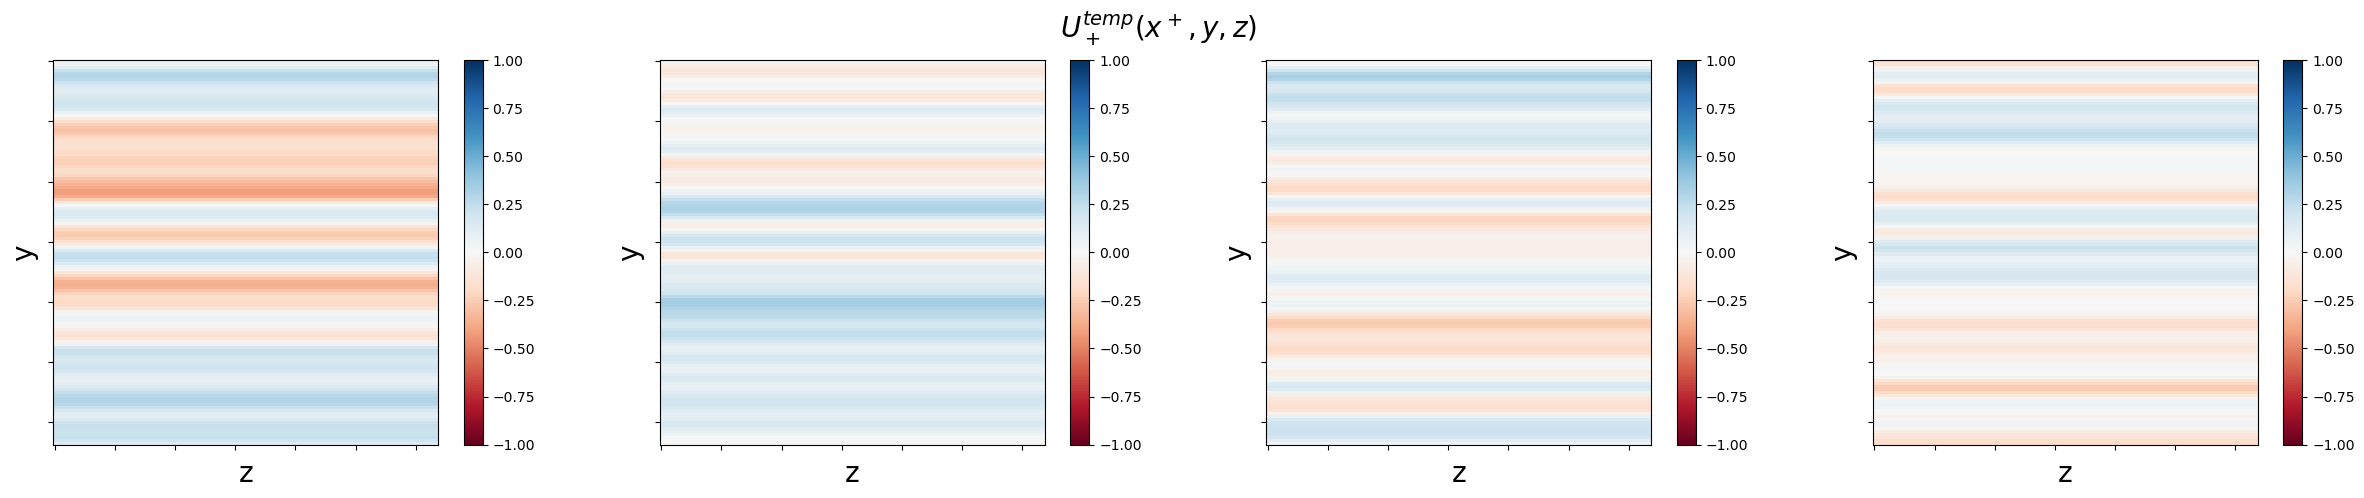

In [14]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$U_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(up_temp_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
# plt.savefig('temporal_gauge_fields', bbox_inches='tight')

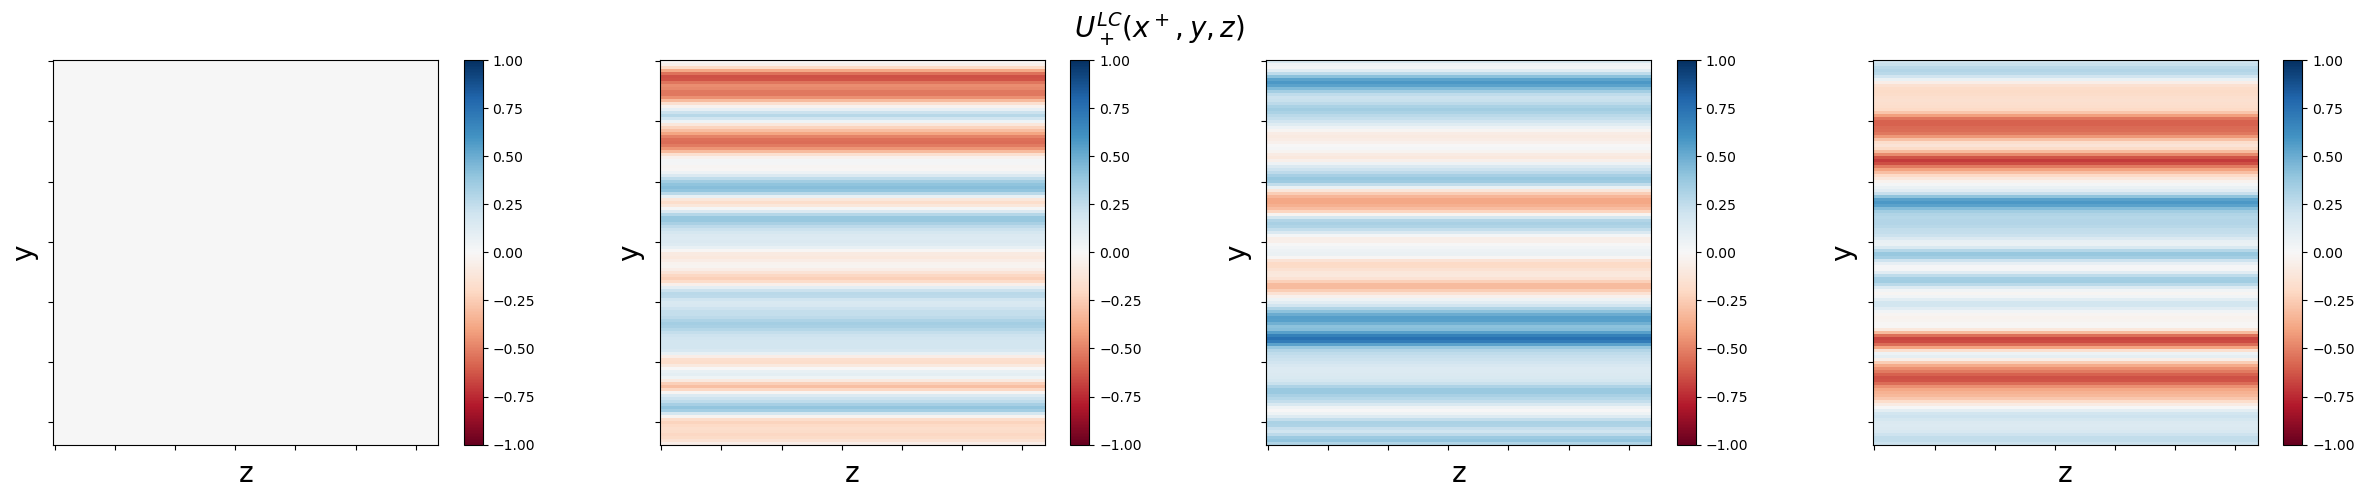

In [15]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$U_+^{LC}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(up_lc_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
# plt.savefig('lc_gauge_fields', bbox_inches='tight')

Let us create a new simulation to check the gauge transformation with the plaquettes

In [3]:
from tqdm import tqdm 

# Simulation routine
def simulate():
    
    # Dictionary to store the results
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N/L*hbarc
    DT = 1.0/DTS 
    maxt = int(tau_sim/a*DTS)
    
    # We create the object Glasma Simulation
    s = core.Simulation(N, DT, g)
    
    # We intialize the Glasma fields
    va = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create an object to store the fields at every time step
    ux_sim = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the plaquette before the gauge transformation
    upm_temp = np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the gauge inavriant
    res_temp = np.zeros((maxt//DTS-1, N, N), dtype=su.GROUP_TYPE)
    
    # We create an object to store the transformed fields at x^- = 0 and x^- = 1
    up_lc = np.zeros((2, maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the gauge transformation operator at x^- = 0 and x^- = 1
    vlc_dag = np.zeros((2, maxt//DTS, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the plaquette after the gauge transformation
    upm_lc = np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the gauge invariant object after the gauge transformation
    res_lc = np.zeros((maxt//DTS-1, N, N), dtype=su.GROUP_TYPE)
    
    # We create an object to store the rest of the gauge invariants
    res = np.zeros((maxt//DTS-1, N, N), dtype=su.GROUP_TYPE)
    
    # We first simulate the Glasma event and store the fields
    for t in range(maxt):
        #Evolve the Glasma fields
        core.evolve_leapfrog(s)
        
        # When we reach a multiple of DTS we store the plus links
        if t%DTS == 0:
            u1 = s.u1.copy()
            ux_sim[t//DTS] = u1[:, 0, :].reshape(N, N, su.GROUP_ELEMENTS)
    
    
    # We now perform the gauge transformation and do the checks
    with tqdm(total=maxt//DTS-1) as pbar:
        for xplus in range(maxt//DTS-1):
                
            for y in range(N):
                for z in range(N):
                        
                    # We compute the plaquette at every time step
                    if xplus != 0:
                        aux1 = su.mul(ux_sim[(xplus-1), (xplus-1), y], su.dagger(ux_sim[(xplus-1)+1, (xplus-1), y]))
                        aux2 = su.mul(su.dagger(ux_sim[(xplus-1)+1, (xplus-1)-1, y]), ux_sim[(xplus-1), (xplus-1)-1, y])
                            
                        upm_temp[(xplus-1), y, z] = su.mul(aux1, aux2)
                            
                        # We compute the gauge invariant object
                        s1 = su.mul_s(su.unit(), 2)
                        s2 = su.mul_s(upm_temp[(xplus-1), y, z], -1)
                        s3 = su.mul_s(su.dagger(upm_temp[(xplus-1), y, z]), -1)
                            
                        s4 = su.add(s1, s2)
                        s5 = su.add(s4, s3)
                            
                        res_temp[(xplus-1), y, z] = su.tr(s5)
                        
                    # We compute the gauge transformation operator at x^+ = 0
                    vlc0 = su.unit(); vlc1 = su.unit()
                    for xminus in range(0, -xplus, -1):
                        vlc1 = su.mul(vlc0, ux_sim[xplus+xminus-1, xplus-xminus, y])
                        vlc0 = np.copy(vlc1)
                    vlc_dag[0, xplus, y] = vlc1
                        
                    # We compute the gauge transformation operator at x^+ = 1
                    vlc0 = su.unit(); vlc1 = su.unit()
                    for xminus in range(1, -xplus, -1):
                        vlc1 = su.mul(vlc0, ux_sim[xplus+xminus-1, xplus-xminus, y])
                        vlc0 = np.copy(vlc1)
                    vlc_dag[1, xplus, y] = vlc1
                        
                    # We perform the gauge transformation of the field at the previous time step
                    if xplus != 0:
                        # For x^- = 0
                        aux = su.mul(ux_sim[(xplus-1), (xplus-1), y], vlc_dag[0, xplus, y])
                        up_lc[0, (xplus-1), y, z] = su.mul(su.dagger(vlc_dag[0, (xplus-1), y]), aux)
                            
                        # For x^- = 1
                        aux = su.mul(ux_sim[(xplus-1)+1, (xplus-1)-1, y], vlc_dag[1, xplus, y])
                        up_lc[1, (xplus-1), y, z] = su.mul(su.dagger(vlc_dag[1, (xplus-1), y]), aux)
                            
                        # We compute the plaquette in the lc gauge
                        upm_lc[(xplus-1), y, z] = su.mul(up_lc[0, (xplus-1), y, z], su.dagger(up_lc[1, (xplus-1), y, z]))
                            
                        # We compute the gauge invariant object in the lc gauge
                        s1 = su.mul_s(su.unit(), 2)
                        s2 = su.mul_s(upm_lc[(xplus-1), y, z], -1)
                        s3 = su.mul_s(su.dagger(upm_lc[(xplus-1), y, z]), -1)
                            
                        s4 = su.add(s1, s2)
                        s5 = su.add(s4, s3)
                            
                        res_lc[xplus-1, y, z] = su.tr(s5)
                    
                    # We compute the rest of the gauge invariant before and after the gauge transformation
                    if xplus != 0:
                        res[xplus-1, y, z] = res_temp[xplus-1, y, z]-res_lc[xplus-1, y, z]
                            
                        
                            
            pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    
    output['res_temp'] = res_temp
    output['res_lc'] = res_lc
    output['res'] = res
    
    return output

In [4]:
# We perform the simulation
import warnings
warnings.filterwarnings('ignore')

output = simulate()
res_temp = output['res_temp']
res_lc = output['res_lc']
res = output['res']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Kernel xi: 0 d:  0 did not reach goal. check:  0.00052172406135264
Kernel xi: 0 d:  1 did not reach goal. check:  0.0021382933589555553
Kernel xi: 1 d:  0 did not reach goal. check:  0.0007293397382957421
Kernel xi: 1 d:  1 did not reach goal. check:  0.0013455741784015446
Kernel xi: 2 d:  0 did not reach goal. check:  0.0009558922039770447
Kernel xi: 2 d:  1 did not reach goal. check:  0.0006503878784609788
Kernel xi: 3 d:  0 did not reach goal. check:  0.0008310985780946307
Kernel xi: 3 d:  1 did not reach goal. check:  0.0005977940821624556
Kernel xi: 4 d:  0 did not reach goal. check:  0.001390698871304337
Kernel xi: 4 d:  1 did not reach goal. check:  0.001524743004223435
Kernel xi: 5 d:  0 did not reach goal. check:  0.0029758693852457194
Kernel xi: 5 d:  1 did not reach goal. check:  0.0028855790184217074
Kernel xi: 6 d:  0 did not reach goal. check:  0.004672176923137379
Kernel xi: 6 d:  1 did not reach goal. check:  0.00587726776468665
Kernel xi: 7 d:  0 did not reach goal. ch

100%|██████████| 63/63 [02:05<00:00,  1.99s/it]


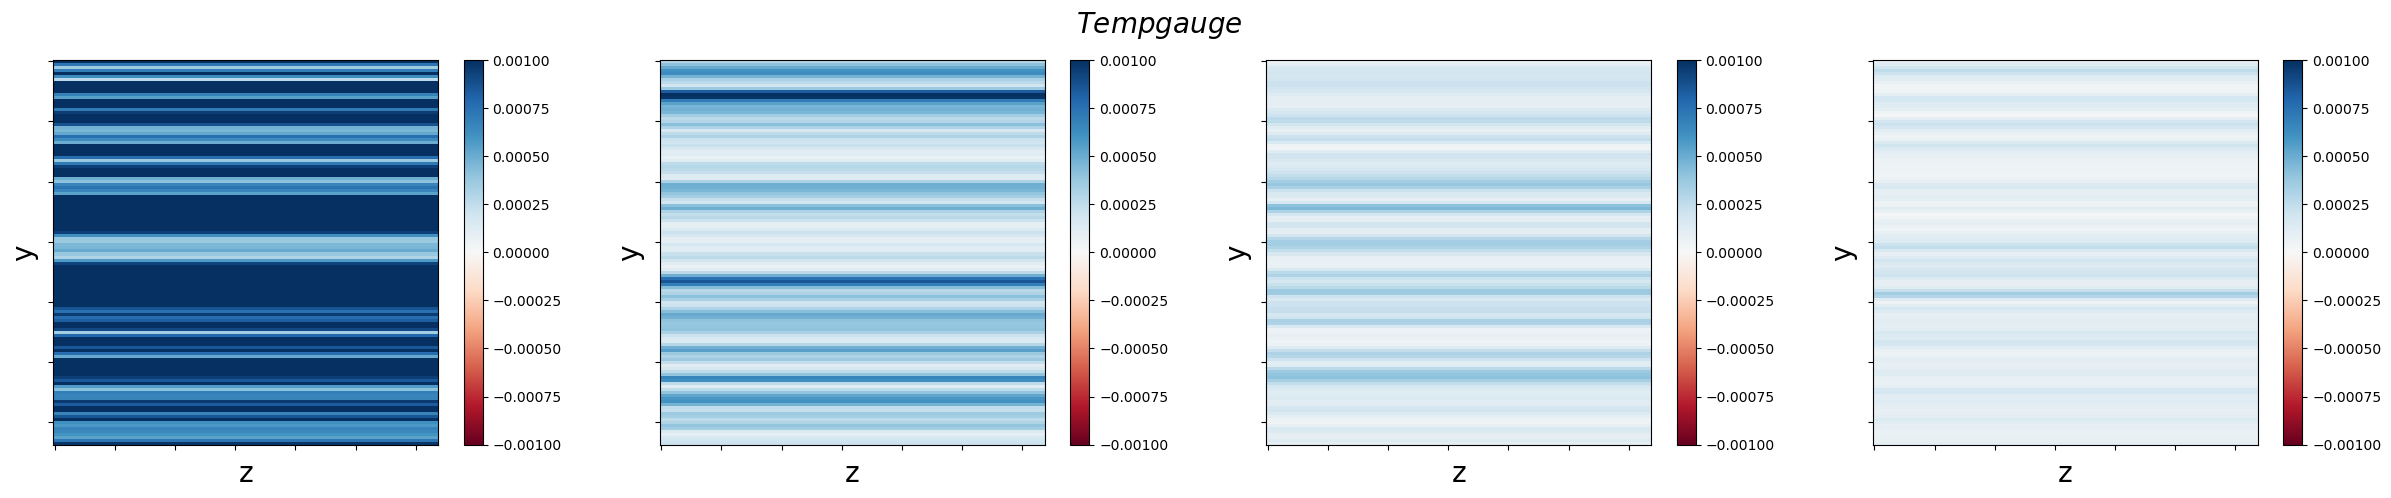

In [5]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$Temp gauge$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(res_temp[tau, :, :].real, cmap='RdBu', vmin=-0.001, vmax=0.001) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
plt.savefig('test_before_trans', bbox_inches='tight')

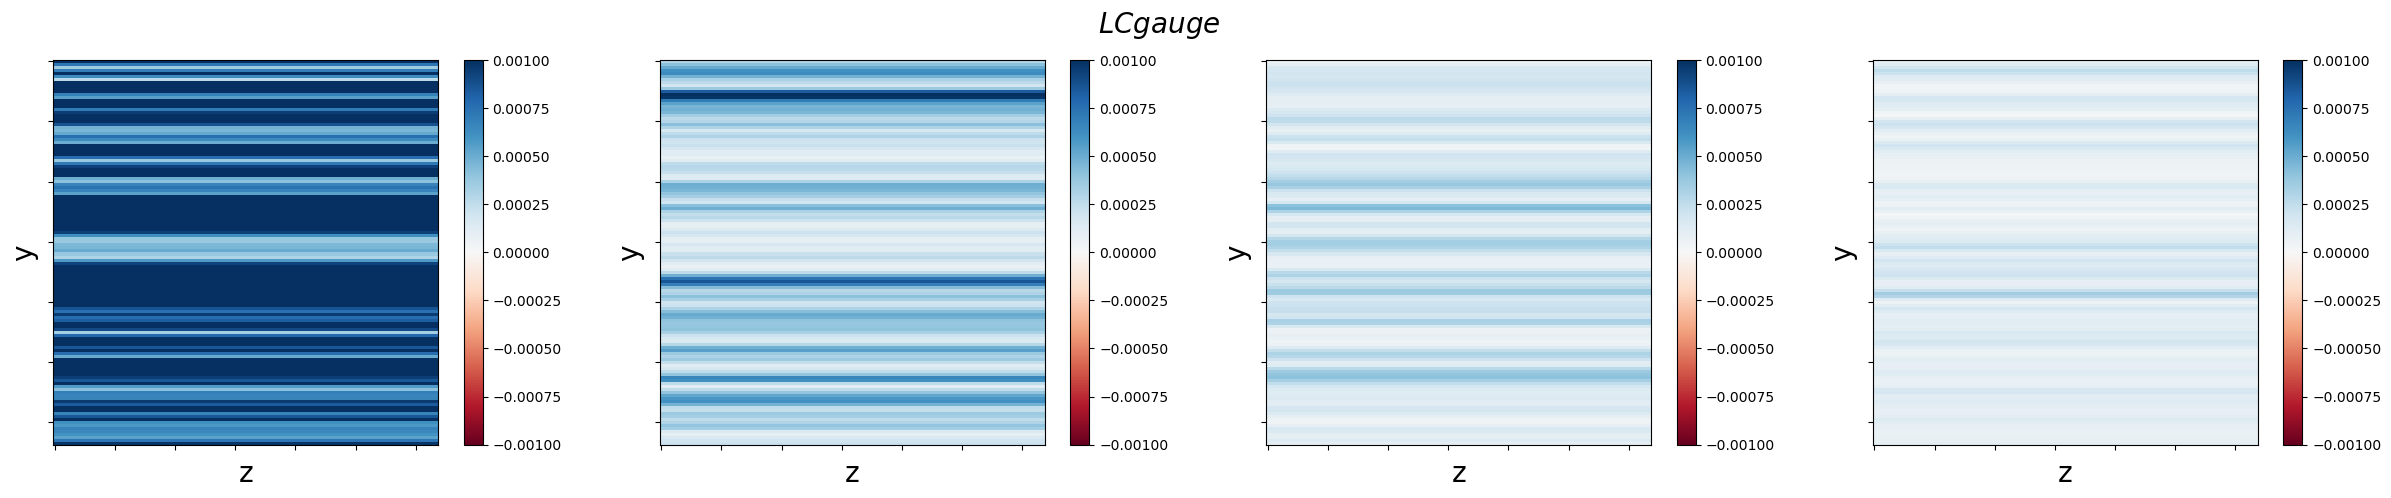

In [6]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$LC gauge$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(res_lc[tau, :, :].real, cmap='RdBu', vmin=-0.001, vmax=0.001) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
plt.savefig('test_after_trans', bbox_inches='tight')

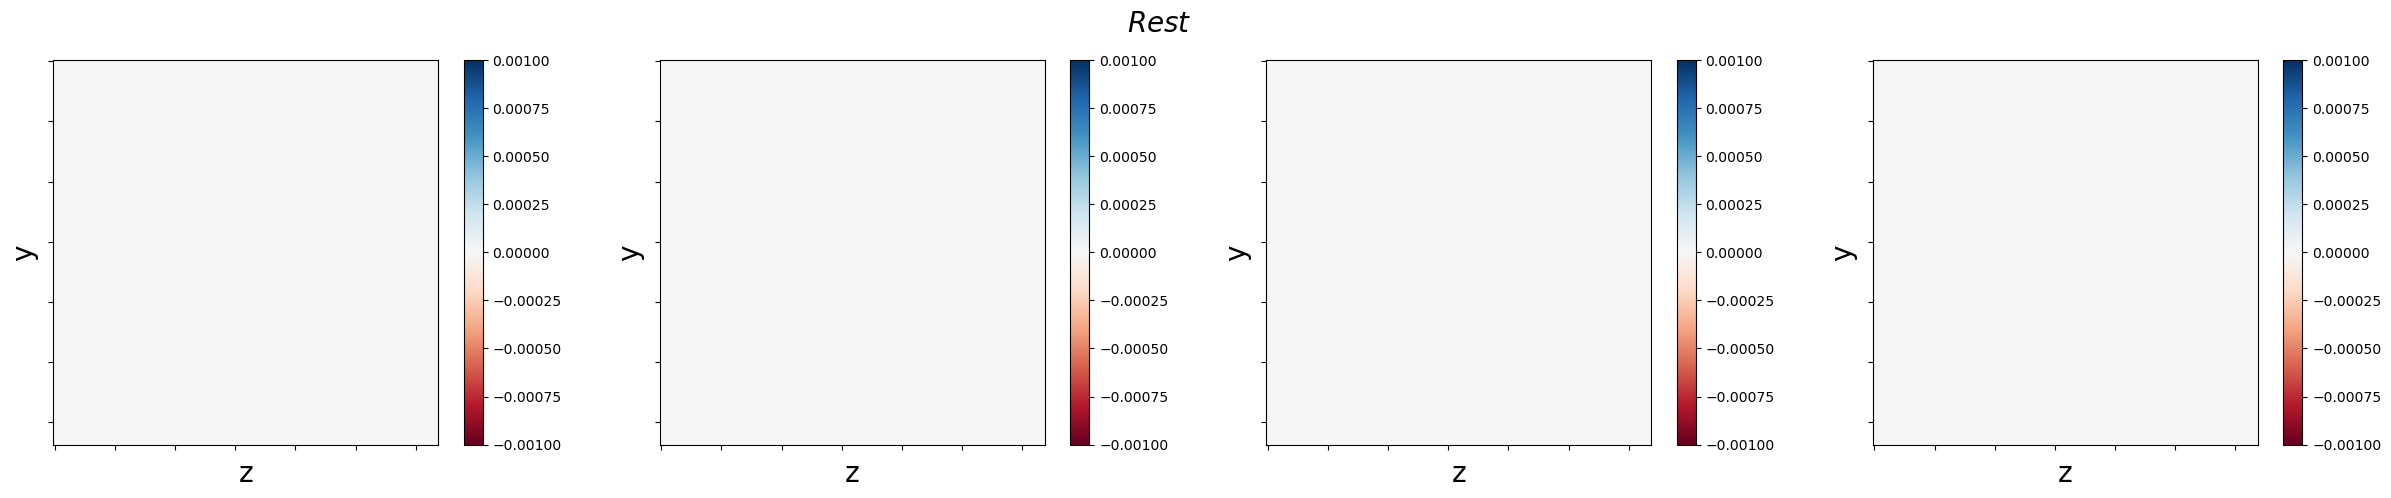

In [7]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$Rest$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(res[tau, :, :].real, cmap='RdBu', vmin=-0.001, vmax=0.001) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
plt.savefig('test_rest', bbox_inches='tight')